<a href="https://colab.research.google.com/github/schumbar/SJSU_CMPE255/blob/main/assignment_05/d_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 05: Data preparation and Processing - Image
## Image Data Set
By Shawn Chumbar
  
Please note that I have used ChatGPT to assist me with this assignment.

Sources:
1. [Dataset Link](https://www.kaggle.com/competitions/dogs-vs-cats/data)
2. ChatGPT-4
3. [Dogs and Cats Classification using TensorFlow](https://www.kaggle.com/code/databeru/dogs-cats-classification-tensorflow-acc-99-25#Dogs&Cats-classification-with-Deep-LearningDogs&Cats-classification-with-Deep-Learning)

Please note: I have borrowed heavily from the Dogs and Cats Classification using Tensorflow link. I was attempting to get ChatGPT to classify dog and cat images, but ChatGPT was having a hard time figuring it out. I just want to be very explicit that a lot of this code was copy and pasted from the linked notebook.

**Tasks:**

For each of the data set types, we must perform the following tasks:
1. Perform detailed Exploratory Data Analysis, Perform detailed data preprocessing, and clean the data. (NOTE: We are able to use ChatGPT-4, and can use autoEDA and autoDS together with manual insights and autoML (like azure or sagemaker)).
2. Perform clustering and anomaly eliminations within the data sets. Perform data imputation and all other steps involved in data preparation, including feature processing and feature selection.
3. Build various ML models using AutoML including ensemble models.
4. Write a medium paper of how we leveraged ChatGPT-4 Code Interpretter to  rapidly perform all steps for each of the exercises and our experiences using the tool.  
5. Submit a link to the medium article.


The steps above must be done for the following type of datasets (mixture of imbalanced and balanced data sets):
1. Tabular diverse set of data types (i.e. NYC Taxi)
2. Timeseries
3. Spatio Temporal
4. Image (i.e. Kerascv or any other popular package)
5. Audio
6. Video (Action Recognition)
7. Graph data set (i.e. citation, etc.)

### Setup
This section should be ran before anything else runs.

In [1]:
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow

In [2]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle

### Retrieve Kaggle Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/CMPE255"

In [16]:
#changing the working directory
%cd "/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image"
%pwd
#Check the present working directory using pwd command

/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image


'/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image'

In [13]:
%rm -Rf *
%ls

In [15]:
%ls
%pwd

'/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image'

In [17]:
!kaggle datasets download -d chetankv/dogs-cats-images

100% 434M/435M [00:22<00:00, 23.0MB/s]
100% 435M/435M [00:22<00:00, 20.6MB/s]


In [18]:
%ls

dogs-cats-images.zip


In [19]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip

# !unzip \*.zip
%ls

Streaming output truncated to the last 5000 lines.
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_

### Remove unneeded files

In [20]:
%ls

 dataset/   dogs-cats-images.zip  'dog vs cat'/


In [21]:
%rm dogs-cats-images.zip

In [22]:
%ls

 dataset/  'dog vs cat'/


In [23]:
import tensorflow as tf
print(tf.__version__)

2.14.0


### Setup Functions
The functions below will be used in the image classification step.

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [25]:
# Create a list with the filepaths for training and testing
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image/dataset/training_set')
train_filepaths = list(dir_.glob(r'**/*.jpg'))

dir_ = Path('/content/drive/MyDrive/Colab Notebooks/CMPE255/assignment_05/datasets/d_image/dataset/test_set')
test_filepaths = list(dir_.glob(r'**/*.jpg'))

In [26]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

In [27]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures in the training dataset: {train_df.shape[0]}\n')
print(f'Number of pictures in the test dataset: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training dataset: 8000

Number of pictures in the test dataset: 2000

Number of different labels: 2

Labels: ['cats' 'dogs']


Filepath Label
0  /content/drive/MyDrive/Colab Notebooks/CMPE255...  cats
1  /content/drive/MyDrive/Colab Notebooks/CMPE255...  cats
2  /content/drive/MyDrive/Colab Notebooks/CMPE255...  dogs
3  /content/drive/MyDrive/Colab Notebooks/CMPE255...  cats
4  /content/drive/MyDrive/Colab Notebooks/CMPE255...  cats

### EDA
We are going to perform Exploratory Data Analysis to see the number of pictures within each category. We want to make sure that there are an equal number of pictures so that the results are not skewed.

#### Data Visualizations

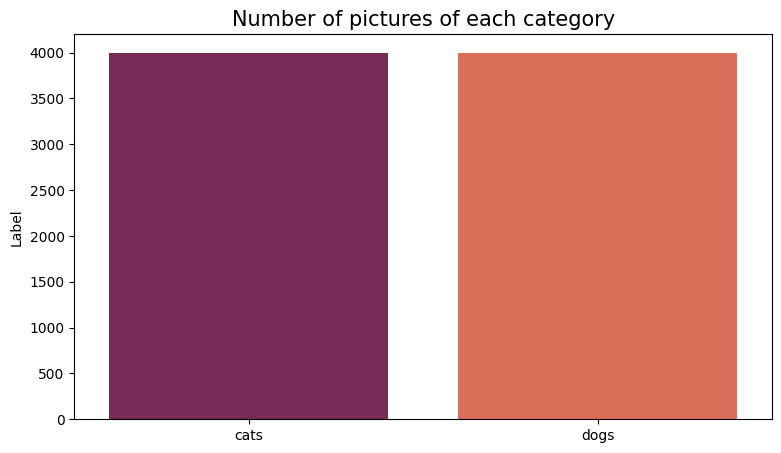

In [28]:
# Display the number of pictures of each category
vc = train_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [29]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

The pictures above show the various pictures that we are working with.

In [30]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [31]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Training the model

In [32]:
# Dictionary with the models
models = {
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0},
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 7200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


219055592/219055592 [==============================] - 12s 0us/step
InceptionResNetV2    trained in 48.35 sec
83683744/83683744 [==============================] - 5s 0us/step
Xception             trained in 26.78 sec
29084464/29084464 [==============================] - 2s 0us/step
DenseNet121          trained in 31.78 sec
87910968/87910968 [==============================] - 5s 0us/step
InceptionV3          trained in 29.09 sec
9406464/9406464 [==============================] - 2s 0us/step
MobileNetV2          trained in 26.56 sec
51877672/51877672 [==============================] - 3s 0us/step
DenseNet169          trained in 34.08 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 37.93 sec
19993432/19993432 [==============================] - 2s 0us/step
N

In [33]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

63/63 [==============================] - 8s 90ms/step


### Model Evaluation

In [34]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  val_accuracy  accuracy  Training time (sec)
0   InceptionResNetV2        0.9962    0.9910                48.35
1         DenseNet201        0.9962    0.9910                37.93
2         DenseNet121        0.9925    0.9885                31.78
3         MobileNetV2        0.9900    0.9885                26.56
4         InceptionV3        0.9925    0.9860                29.09
5         ResNet101V2        0.9887    0.9835                30.69
6        NASNetMobile        0.9912    0.9790                40.36
7         DenseNet169        0.9887    0.9780                34.08
8            Xception        0.9900    0.9715                26.78
9           ResNet101        0.6550    0.6600                31.72
10          ResNet152        0.5850    0.6100                35.94

In [35]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

As we can see from the picture above, the most accurate model is the InceptionResNetV2 model.

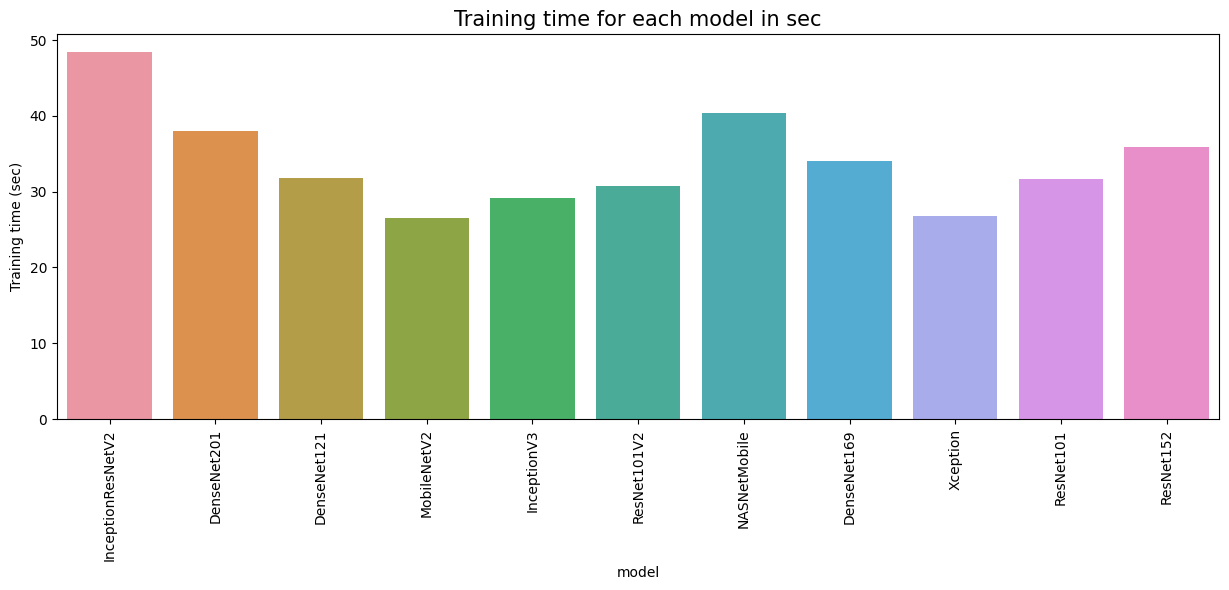

In [36]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [37]:
# Create and train the model
model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True)]
                    )

Epoch 1/50
225/225 [==============================] - 38s 124ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 0.0094 - val_accuracy: 0.9962
Epoch 2/50
225/225 [==============================] - 24s 108ms/step - loss: 0.0198 - accuracy: 0.9928 - val_loss: 0.0141 - val_accuracy: 0.9975
Epoch 3/50
225/225 [==============================] - 25s 111ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0236 - val_accuracy: 0.9925
Epoch 4/50
225/225 [==============================] - 25s 110ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.0188 - val_accuracy: 0.9962
Epoch 5/50
225/225 [==============================] - 25s 111ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0420 - val_accuracy: 0.9887
Epoch 6/50
225/225 [==============================] - 25s 110ms/step - loss: 0.0057 - accuracy: 0.9971 - val_loss: 0.0236 - val_accuracy: 0.9950
Epoch 7/50
225/225 [==============================] - 24s 105ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.0226 - val_ac

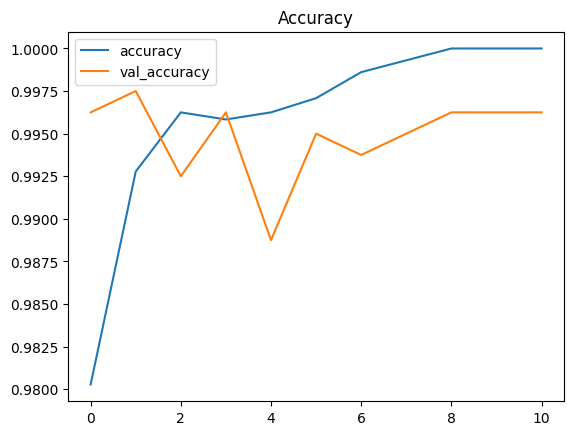

In [38]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [39]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

63/63 [==============================] - 9s 97ms/step


# Accuracy on the test set: 99.35%

In [41]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (4,3))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

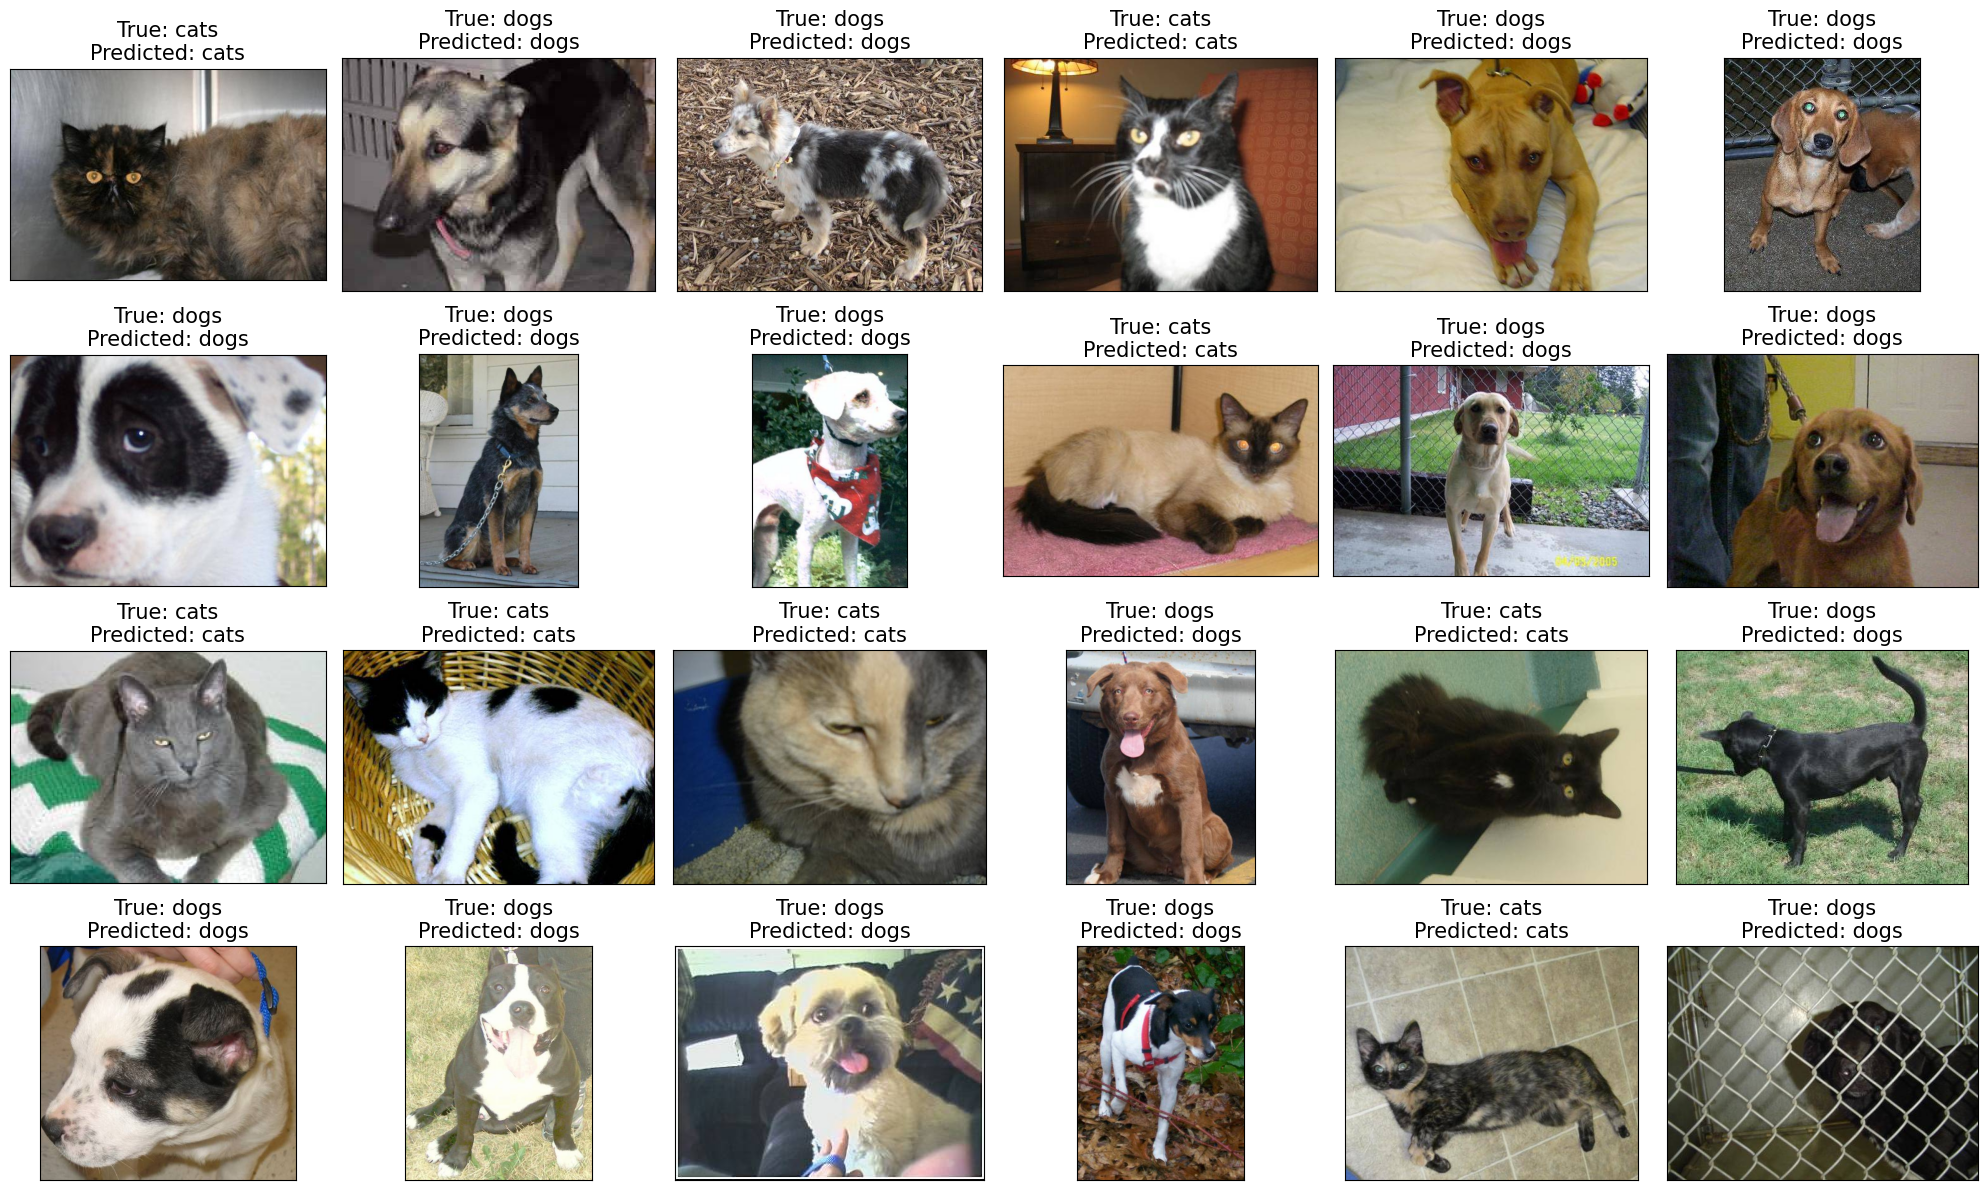

In [42]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

### Conclusion

In this project, we embarked on a comprehensive journey starting from raw image data to sophisticated classification models. Initially, our environment setup involved preparing the necessary libraries essential for image processing, data manipulation, and deep learning. Following this, we retrieved a substantial dataset from Kaggle, containing diverse images of dogs and cats.

Our exploratory data analysis was instrumental in understanding the distribution of our image categories. We ensured a balanced dataset to prevent model bias during training, contributing to the robustness of our subsequent analysis.

The core of our project was utilizing advanced machine learning models for image classification. Among the contenders, the InceptionResNetV2 model stood out with superior accuracy, demonstrating its effectiveness in distinguishing between the intricate features of the images.

Our journey underscores the importance of meticulous data preparation, the power of deep learning in image recognition, and the nuances of model selection. Future endeavors might explore further model optimization, experiment with additional data augmentation techniques, or expand the dataset to include more categories for a broader classification system.


NOTE: I want to be very explicit that I used a lot of code that I had found in the kaggle notebook detailed in the sources section at the top of this notebook.